In [3]:
import sys
sys.path.append('../')

import numpy as np
import torch
import torch.nn as nn
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split 
from tqdm import tqdm
from clearml import Task
import torch.optim as optim

from nn.models import CNN, MLP, DeepCNN, VisionTransformer
from nn.train_val_test import train_epoch, test, display_losses
from nn.dataset import MatricesDataset


In [6]:
config = {
    'dataset':{
        'target_name': 'h11',
        'class_label': 'original',
        'capacity': 0.1,
        'test_size': 0.3,
        'num_workers': 2,
        'train_batch': 2048,
        'validation_batch': 2048,
        'test_batch': 2048,
    },
    'model':{
        'device': 'cuda',
        'name': 'VisionTransformer'
    },
    'train':{
        'num_epochs': 30,
        'learning_rate': 1e-2,
        'weight_decay': 1e-5,
    }
}

class vit_config():
    def __init__(self):
        self.num_patches=20
        self.patch_size=4
        self.embed_dim=32
        self.pool_size=2
        self.num_layers=2
        self.num_heads=1
        self.mlp_dim=256
        self.out_dim=1

model_config = vit_config()

In [3]:
task = Task.init(project_name="cicy4folds", task_name=f"{config['dataset']['target_name']}_{config['model']['name']}_train")
task.connect(config, name='Train config')

ClearML Task: overwriting (reusing) task id=2e35171633304471b1c9155baad35ab3
2024-08-01 15:05:09,578 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2024-08-01 15:05:09,580 - clearml.Repository Detection - WARNING - Please install nbconvert using "pip install nbconvert"
2024-08-01 15:05:09,620 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/2e3a3c9f3a5d425f9af1864b8e2658f7/experiments/2e35171633304471b1c9155baad35ab3/output/log


{'dataset': {'target_name': 'h11',
  'class_label': 'original',
  'capacity': 0.1,
  'test_size': 0.3,
  'num_workers': 2,
  'train_batch': 2048,
  'validation_batch': 2048,
  'test_batch': 2048},
 'model': {'device': 'cuda', 'name': 'DeepCNN'},
 'train': {'num_epochs': 30, 'learning_rate': 0.01, 'weight_decay': 1e-05}}

# Dataset

In [4]:
with open('data/padded_matrices', 'rb') as f:
    matrices = pickle.load(f)

df = pd.read_csv('data/cicy4folds_extended.csv')
df = df.replace('Null', np.nan)
nan_indeces = df.index[df.isna().any(axis=1)].tolist()

df_clear = df.drop(nan_indeces)
matrices_clear = np.delete(matrices, nan_indeces, axis=0)

assert len(df_clear)==len(matrices_clear)

In [25]:
with open('data/padded_matrices_small.pickle', 'wb') as f:
    pickle.dump(matrices_clear, f)

df_clear.to_csv('data/cicy4folds_extended_small.csv')

In [5]:
size_old_dataset = len(df_clear)
if config['dataset']['capacity']<1:
    selected_indices = np.random.choice(np.arange(0, round(size_old_dataset)), size=round(config['dataset']['capacity']*size_old_dataset), replace=False)
    df_clear = df_clear.iloc[selected_indices]
    matrices_clear = matrices_clear[selected_indices]
print(f"Size of dataset is {len(matrices_clear)} matrices, which is {len(matrices_clear)/size_old_dataset*100:.2f} % of full dataset")

Size of dataset is 90568 matrices, which is 10.00 % of full dataset


In [6]:
df_train_validate, df_test, matrices_train_validate, matrices_test = train_test_split(df_clear, matrices_clear, test_size=config['dataset']['test_size'], shuffle=True)
df_train, df_validate, matrices_train, matrices_validate = train_test_split(df_train_validate, matrices_train_validate, test_size=config['dataset']['test_size'], shuffle=True)

In [7]:
train_ds = MatricesDataset(df_train, matrices_train, config['dataset']['target_name'])
validate_ds = MatricesDataset(df_validate, matrices_validate, config['dataset']['target_name'])
test_ds = MatricesDataset(df_test, matrices_test, config['dataset']['target_name'])

train_dataloader = DataLoader(train_ds, batch_size=config['dataset']['train_batch'], num_workers=config['dataset']['num_workers'], shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=config['dataset']['test_batch'], num_workers=config['dataset']['num_workers'], shuffle=False)
validate_dataloader = DataLoader(validate_ds, batch_size=config['dataset']['validation_batch'], num_workers=config['dataset']['num_workers'], shuffle=True)

# Model

In [7]:
if (config['model']['name']=='CNN'):
    model = CNN().to(config['model']['device'])
elif (config['model']['name']=='MLP'):
    #model = MLP(model_config).to(config['model']['device'])
    pass
elif (config['model']['name']=='DeepCNN'):
    model = DeepCNN().to(config['model']['device'])
elif (config['model']['name']=='VisionTransformer'):
    model = VisionTransformer(model_config).to(config['model']['device'])
else:
    raise NameError(f"There isn't model with name {config['model']['name']}")

criterion = nn.MSELoss()
optimizer = optim.NAdam(model.parameters(), lr=config['train']['learning_rate'], weight_decay=config['train']['weight_decay'])

c:\Users\User\anaconda3\envs\cicy4folds\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
#model.load_state_dict(torch.load(f"models/{config['model']['name']}_for_{config['dataset']['target_name']}.pth"))

In [10]:
train_loss = []
val_loss = []
min_val_loss = np.inf
for epoch in tqdm(range(config['train']['num_epochs'])):
    losses = train_epoch(model, optimizer, criterion, train_dataloader, validate_dataloader, config)

    print(f"{epoch+1}: loss on train: {losses['train_loss']:.4f}, loss on validation: {losses['validation_loss']:.4f}")
    train_loss.append(losses['train_loss'])
    val_loss.append(losses['validation_loss'])
    if(losses['validation_loss'] < min_val_loss):
        min_val_loss = losses['validation_loss']
        torch.save(model.state_dict(), f"models/{config['model']['name']}_for_{config['dataset']['target_name']}.pth")

    task.get_logger().report_scalar(title="Loss", series="train loss", iteration=(epoch+1), value=losses['train_loss'])
    task.get_logger().report_scalar(title="Loss", series="validation loss", iteration=(epoch+1), value=losses['validation_loss'])
    task.get_logger().report_scalar(title="Accuracy", series="train accuracy", iteration=(epoch+1), value=losses['train_accuracy'])
    task.get_logger().report_scalar(title="Accuracy", series="validation accuracy", iteration=(epoch+1), value=losses['validation_accuracy'])

    

  0%|          | 0/30 [00:00<?, ?it/s]

1: loss on train: 590.6623, loss on validation: 68.6659
2024-08-01 15:05:34,548 - clearml.frameworks - INFO - Found existing registered model id=7cdd30a8eeb14f86a3d6b31b36fae92a [d:\Study\Skoltech\Master's thesis\cicy4folds_project\models\DeepCNN_for_h11.pth] reusing it.


  3%|▎         | 1/30 [00:26<12:40, 26.21s/it]

2: loss on train: 22.6891, loss on validation: 5.3652


  7%|▋         | 2/30 [00:52<12:10, 26.07s/it]

3: loss on train: 4.2772, loss on validation: 3.7203


 10%|█         | 3/30 [01:19<11:58, 26.60s/it]

4: loss on train: 3.6198, loss on validation: 3.5473


 13%|█▎        | 4/30 [01:48<11:58, 27.64s/it]

5: loss on train: 3.3943, loss on validation: 3.0871


 17%|█▋        | 5/30 [02:14<11:14, 27.00s/it]

6: loss on train: 3.1583, loss on validation: 2.9834


 23%|██▎       | 7/30 [02:57<09:05, 23.71s/it]

7: loss on train: 3.1252, loss on validation: 3.6074


 27%|██▋       | 8/30 [03:15<08:01, 21.87s/it]

8: loss on train: 3.1316, loss on validation: 3.4721
9: loss on train: 2.8063, loss on validation: 2.7588


 27%|██▋       | 8/30 [03:37<09:58, 27.20s/it]


KeyboardInterrupt: 

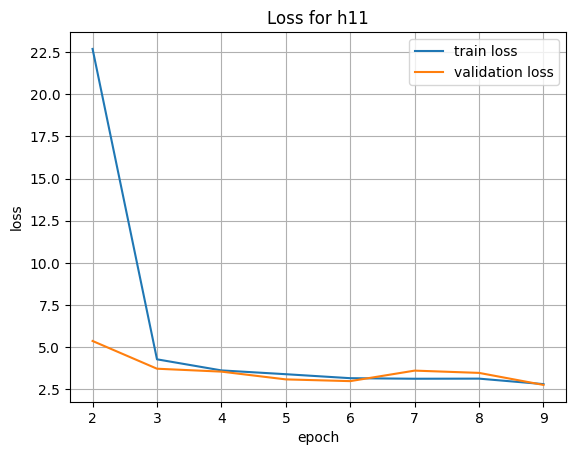

In [11]:
display_losses(train_loss, val_loss, config)

# Evaluation

In [10]:
model.load_state_dict(torch.load(f"../models_weight/{config['model']['name']}_for_{config['dataset']['target_name']}.pth"))

C:\Users\User\AppData\Local\Temp\ipykernel_3036\3413009094.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"../models_weight/{config['m

<All keys matched successfully>

In [13]:
test_metrics = test(model, criterion, test_dataloader, config)
print(f"loss on test: {test_metrics['test_loss']:.3f}, accuracy on test: {test_metrics['test_accuracy']*100:.2f}%, rmse on test: {test_metrics['test_rmse']:.3f}")
test_metrics = pd.DataFrame(test_metrics, index=[f"{config['dataset']['target_name']}_{config['model']['name']}"])

100%|██████████| 14/14 [00:07<00:00,  1.96it/s]

loss on test: 2.715, accuracy on test: 43.04%, rmse on test: 1.648



c:\Users\User\anaconda3\envs\cicy4folds\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [17]:
#new_dataframe_result = pd.DataFrame(columns=['h11', 'h21', 'h31', 'h22'], index=['CNN', 'MLP', 'DeepCNN'])
#new_dataframe_result.to_csv(f"results/{config['dataset']['class_label']}_{config['dataset']['capacity']}_dataset.csv")

In [18]:
dataframe_result = pd.read_csv(f"results/{config['dataset']['class_label']}_{config['dataset']['capacity']}_dataset.csv", index_col=0)
dataframe_result[config['dataset']['target_name']][config['model']['name']] = round(test_metrics['test_accuracy'].item(),3)
dataframe_result.to_csv(f"results/{config['dataset']['class_label']}_{config['dataset']['capacity']}_dataset.csv")
dataframe_result

C:\Users\User\AppData\Local\Temp\ipykernel_6336\3404756473.py:2: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




,h11,h21,h31,h22
CNN,NaN,NaN,NaN,NaN
MLP,NaN,NaN,NaN,NaN
DeepCNN,0.43,NaN,NaN,NaN


In [19]:
task.get_logger().report_table(title='Metrics table', series='pandas DataFrame', iteration=0, table_plot=test_metrics)

In [20]:
task.close()

# Some waste

In [21]:
batch = next(iter(test_dataloader))
model_out = model(batch['matrix'].to(config['model']['device'])).squeeze(-1)
ground_truth = batch['hodge_number'].to(config['model']['device'])

In [22]:
model_out[:14].round()

tensor([11.,  9., 10.,  5., 11.,  9.,  9., 12., 11.,  7., 10.,  8., 11., 11.],
       device='cuda:0', grad_fn=<RoundBackward0>)

In [23]:
ground_truth[:14]

tensor([11.,  9., 11.,  5.,  9., 11.,  9., 14., 11.,  8.,  9.,  8., 16., 12.],
       device='cuda:0')

In [24]:
(model_out.round()==ground_truth).sum().item(), len(ground_truth)

(869, 2048)

C:\Users\User\AppData\Local\Temp\ipykernel_3036\1124621470.py:3: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  a.append(m.std().item())


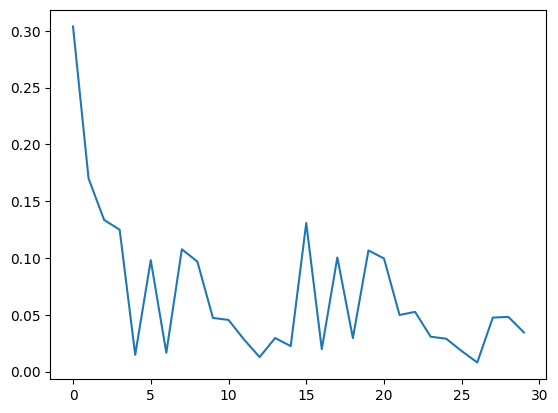

In [18]:
a = []
for m in model.parameters():
    a.append(m.std().item())

plt.plot(a)